In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import fft
from scipy import signal as sig
import warnings
import random 
import math
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq
from scipy import signal as sig
from cmath import phase
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import sympy as sym
from sympy import pi
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, roc_auc_score, f1_score

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
#https://stackoverflow.com/questions/4364823/how-do-i-obtain-the-frequencies-of-each-value-in-an-fft/4371627#4371627

In [2]:
def make_fft(amp, N):
    
    ''' prepare fourier series of amplitude amp and length N '''

    N = N 
    T = 1/1 
    f = 1/amp

    x = np.linspace(0, N*T, N, endpoint=False)
    ft = np.cos(f * 2.0*np.pi*x) + np.sin(f * 2.0*np.pi*x)

    return ft

In [3]:
def test_different_frequencies(data, 
                              train_fold_size,
                               test_fold_size,
                               maximum,
                               step):
    
    
    '''
    test different seasonalities by predicting alpha diversity only with fourier series with given seasonality
    using linear regression and sliding window of size step cross validation
    
    data           : alpha diveristy dataframe
    train_fold_size: train set
    test_fold_size : forecast horizon
    maximum        : max in range
    step           : sliding window step
    
    '''
    
    DF = []
    tested_frequencies = np.arange(2, 35, 1)
    for freq in tested_frequencies: #test different frequencies
    
        data = data

        train_fold_size = train_fold_size
        test_fold_size = test_fold_size
        
        size = train_fold_size + test_fold_size
        exog_fft = make_fft(freq, len(data))


        TRAIN_SCORE = []; TEST_SCORE = []; FREQ = []
        for n in range (0, maximum, step):

            train = data[n:n+train_fold_size].values
            test = data[n+train_fold_size:(n+train_fold_size+test_fold_size)].values
            
            train = train - train.mean()
            test = test - test.mean()
            
            train_fft = exog_fft[n:n+train_fold_size]
            test_fft = exog_fft[n+train_fold_size:(n+train_fold_size+test_fold_size)]


            y_train = pd.DataFrame(train, columns=['shannon']) #shannon
            X_train = pd.DataFrame(train_fft)

            y_test = pd.DataFrame(test, columns=['shannon']) #shannon
            X_test = pd.DataFrame(test_fft)

            model = LinearRegression()
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            #analyse score
            train_score = np.round(stats.spearmanr(train, y_train_pred)[0], 2)
            test_score = np.round(stats.spearmanr(test, y_test_pred)[0], 2)

            TRAIN_SCORE.append(train_score)
            TEST_SCORE.append(test_score)
            FREQ.append(freq)


        rho_df = pd.DataFrame(list(zip(TRAIN_SCORE, TEST_SCORE, FREQ)), columns = ['train_rho', 'test_rho', 'freq'])
        rho_df['fold'] = n

        DF.append(rho_df)
        
    res_df = pd.concat(DF)
        
    return res_df

### MALE SUBJECT

In [6]:
male_shannon_df = pd.read_csv('/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/male_shannon.csv')

In [70]:
#test male frquencies
subject = 'male'
male_freq = test_different_frequencies(male_shannon_df, 
                           50,
                           25,
                           280,
                           10)

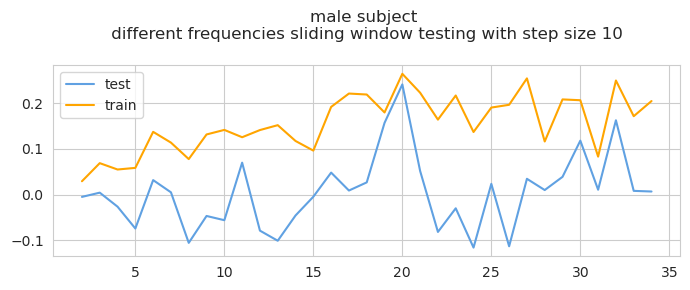

In [76]:
male_freq_g = male_freq.groupby(by = ['freq']).mean().reset_index()

male_freq_g['test_rank'] = male_freq_g.test_rho.rank()
male_freq_g.sort_values(by = 'test_rank').tail(5)

plt.figure(figsize = (7, 3))
plt.plot(male_freq_g.freq, male_freq_g.test_rho, label='test', color='#60A1E2')
plt.plot(male_freq_g.freq, male_freq_g.train_rho, label='train', color='orange')
plt.legend()
plt.title(f'{subject} subject \n different frequencies sliding window testing with step size 10 \n')
plt.tight_layout()
plt.savefig('fft_plots/male_dominant_frequency.png', dpi = 200)

In [72]:
male_freq_g.sort_values(by = 'test_rank').tail(10)

,freq,train_rho,test_rho,fold,test_rank
4,6,0.137500,0.031786,270.0,24.0
25,27,0.254643,0.034643,270.0,25.0
27,29,0.208571,0.038929,270.0,26.0
14,16,0.192143,0.048214,270.0,27.0
19,21,0.223214,0.051786,270.0,28.0
9,11,0.125714,0.070000,270.0,29.0
28,30,0.206786,0.118214,270.0,30.0
17,19,0.180000,0.157143,270.0,31.0
30,32,0.250000,0.162857,270.0,32.0
18,20,0.264643,0.241429,270.0,33.0


In [4]:
#plot 
def plot_prediction(data, 
                    train_fold_size,
                    test_fold_size,
                    maximum,
                    step,
                    freq,
                    detrend = False,
                    multiple_freq = False):
    
    
    data = data
    train_fold_size = train_fold_size
    test_fold_size = test_fold_size
    maximum = maximum
    step = step
    freq = freq
    
    if multiple_freq == False:
        
        exog_fft = make_fft(freq, len(data))
    
    elif multiple_freq == True:
        
        exog_fft = 0
        
        for f in freq:
            exog_vars = make_fft(f, len(male_shannon_df))
            exog_fft += exog_vars

    DF = []
    for n in range (0, maximum, step):
        try:

            train = data[n:n+train_fold_size].values
            test = data[n+train_fold_size:(n+train_fold_size+test_fold_size)].values

            if detrend == True:
                train = train - train.mean()
                test = test - test.mean()
            elif detrend == False:
                pass

            train_fft = exog_fft[n:n+train_fold_size]
            test_fft = exog_fft[n+train_fold_size:(n+train_fold_size+test_fold_size)]

            y_train = pd.DataFrame(train, columns=['shannon']) #shannon
            X_train = pd.DataFrame(train_fft)

            y_test = pd.DataFrame(test, columns=['shannon']) #shannon
            X_test = pd.DataFrame(test_fft)

            model = LinearRegression()
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)


            if detrend == True:

                y_train_pred = y_train_pred - train.mean()
                y_test_pred = y_test_pred - test.mean()

            elif detrend == False:
                pass

            #analyse score
            train_score = np.round(stats.spearmanr(train, y_train_pred)[0], 2)
            test_score = np.round(stats.spearmanr(test, y_test_pred)[0], 2)

            true = np.concatenate((train, test), axis=0)
            prediction = np.concatenate((y_train_pred, y_test_pred), axis=0)

            #plot results

            plt.figure(figsize = (7, 3))

            plt.plot(true, 'ko-.', label='y')
            plt.plot(prediction, 'r-', lw=2, label='ypred')
            plt.legend()
            plt.title(f'prediction using only Fourier series with freq {np.round(freq, 2)} \n train rho:{train_score}, test rho:{test_score} \n')
            plt.axvline(50, color='green')
            plt.tight_layout()
            plt.savefig(f'fft_plots/fft_lin_reg_pred/{subject}_prediction_fft_lin_reg_{n}.png', dpi=200)
            plt.show()
            
        except:
            pass

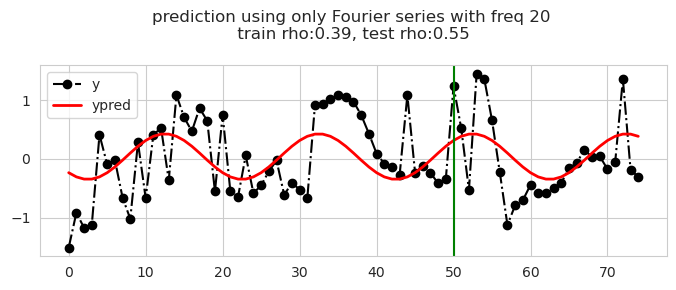

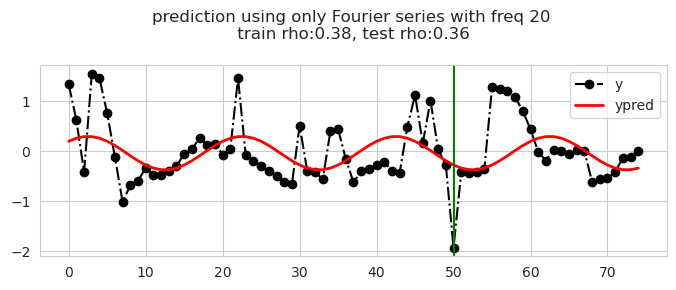

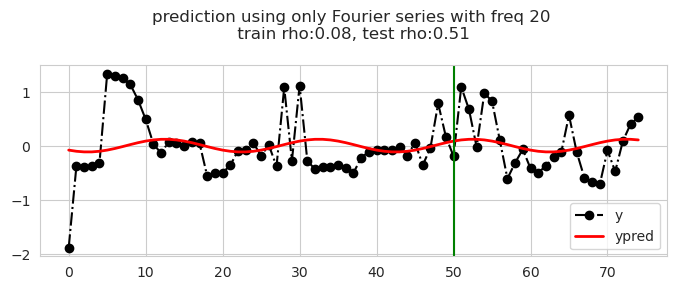

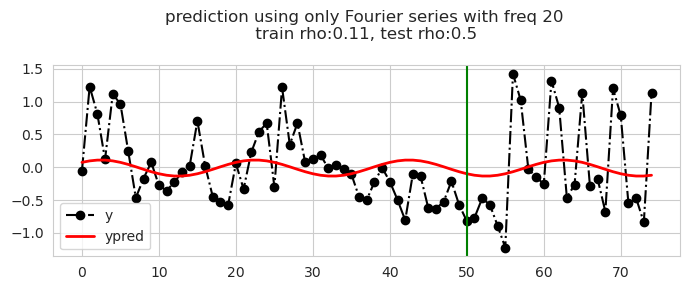

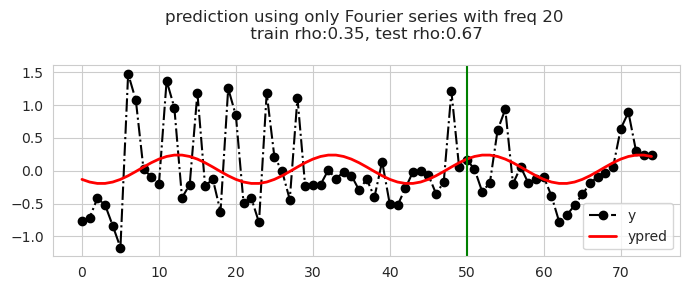

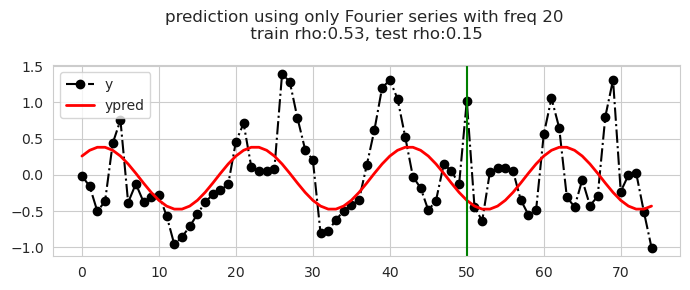

In [7]:
plot_prediction(male_shannon_df, 50, 25, 300, 50, 20, True)

### FEMALE SUBJECT

In [9]:
female_shannon_df = pd.read_csv('/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/female_shannon.csv', index_col = [0])
subject = 'female'

In [11]:
#test female frquencies
female_freq = test_different_frequencies(female_shannon_df, 
                           50,
                           25,
                           140,
                           10)

In [12]:
female_freq_g = female_freq.groupby(by = ['freq']).mean().reset_index()

female_freq_g['test_rank'] = female_freq_g.test_rho.rank()
female_freq_g.sort_values(by = 'test_rho').tail(10)

,freq,train_rho,test_rho,fold,test_rank
32,34,0.172857,0.021429,130.0,24.0
9,11,0.167857,0.032857,130.0,25.0
29,31,0.180000,0.042857,130.0,26.0
11,13,0.227143,0.050714,130.0,27.0
4,6,0.077143,0.070000,130.0,28.0
12,14,0.208571,0.071429,130.0,29.0
8,10,0.120000,0.081429,130.0,30.0
16,18,0.076429,0.085714,130.0,31.0
5,7,0.097143,0.100714,130.0,32.0
10,12,0.265714,0.103571,130.0,33.0


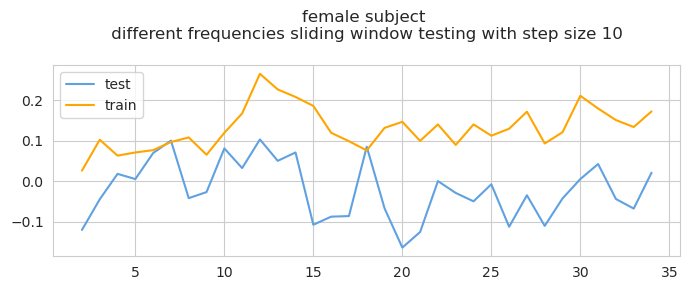

In [17]:
plt.figure(figsize = (7, 3))
plt.plot(female_freq_g.freq, female_freq_g.test_rho, label='test', color='#60A1E2')
plt.plot(female_freq_g.freq, female_freq_g.train_rho, label='train', color='orange')
plt.legend()
plt.title(f'{subject} subject \n different frequencies sliding window testing with step size 10 \n')
plt.tight_layout()
plt.savefig(f'fft_plots/{subject}_dominant_frequency.png', dpi = 200)

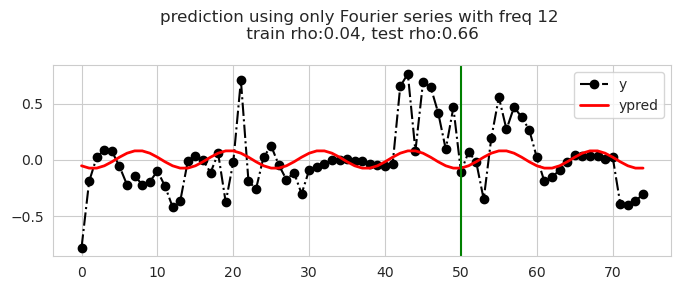

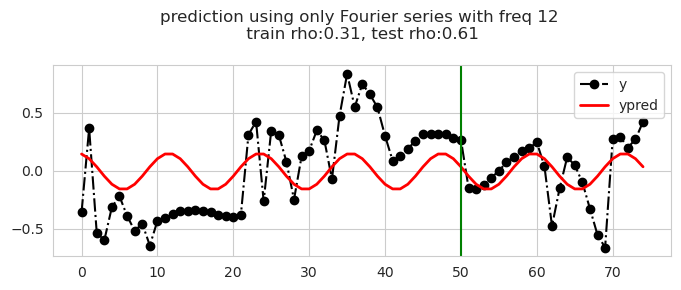

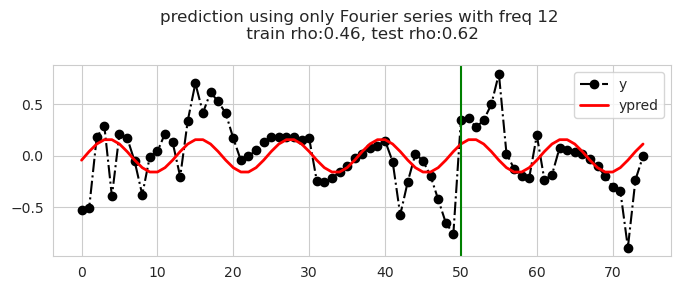

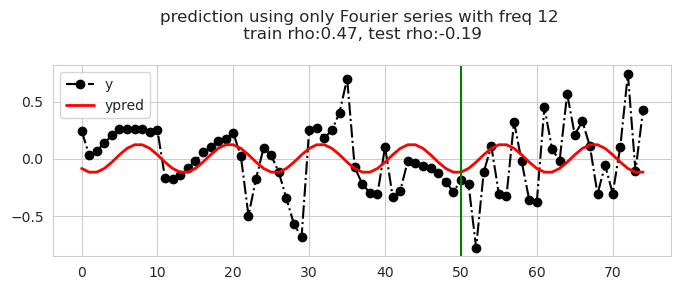

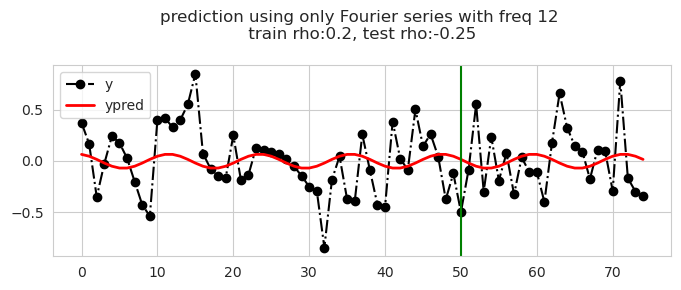

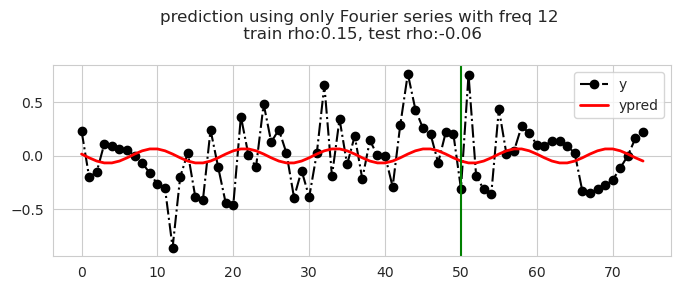

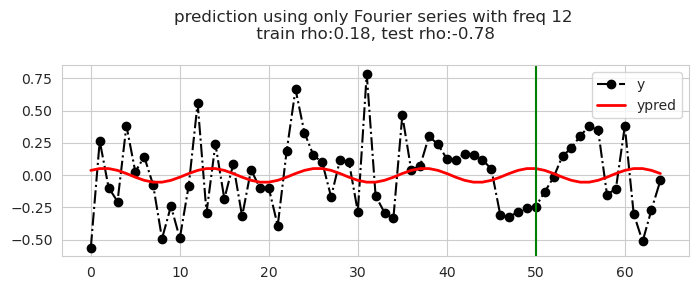

In [21]:
plot_prediction(female_shannon_df, 50, 25, 140, 20, 12, True, False)

In [2]:
import xgboost
import pandas as pd


male_shannon_df = pd.read_csv('/storage/zkarwowska/microbiome-dynamics-preprint/datasets/alpha_diversity/male_shannon.csv')
train = male_shannon_df[:100]
test = male_shannon_df[100:150]

model = XGBRegressor()